In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
store_path = "ddpm_model.pt"

batch_size = 128
epochs = 20
lr = 0.001

In [ ]:
def show_images(images, title=""):
    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # 8 x 8
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.axis(False)
                idx += 1
    fig.suptitle(title, fontsize=30)
    plt.show()

In [ ]:
# Convert to tensor and normalize between [-1, 1]
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)

# dataset = MNIST("./datasets", download=True, train=True, transform=transform)
dataset = FashionMNIST("./datasets", download=True, train=True, transform=transform)

loader = DataLoader(dataset, batch_size, shuffle=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]


Extracting ./datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 167kB/s]


Extracting ./datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.19MB/s]


Extracting ./datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.78MB/s]

Extracting ./datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



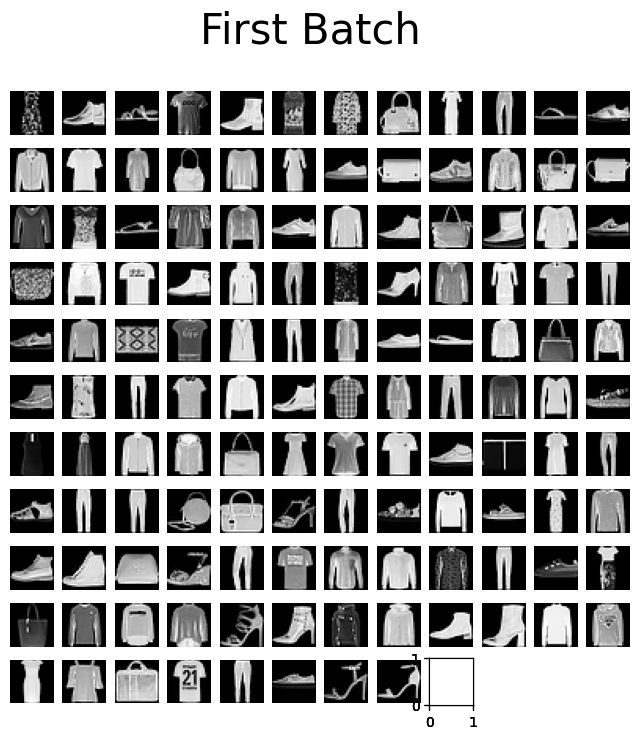

In [ ]:
show_images(next(enumerate(loader))[1][0], "First Batch")

Initialization -

$\beta$ is a linear range from `min_beta` to `max_beta` with `n_steps` steps.

$\beta_t$ is a small noise variance.

$\alpha_t \approx 1 - \beta _t$

$\bar \alpha_t \approx \prod _{s=1}^t \alpha_s$

Forward Process of Diffusion -

Given an image $x$ and time step $t$, the function returns a noisy version:

$
x_t = \sqrt{\bar{\alpha}_t}\, x + \sqrt{1-\bar{\alpha}_t}\, \eta
$

In [ ]:
class DDPMModel(nn.Module):
  def __init__(self,
               network,
               n_steps=200,
               min_beta=10**-4, # Min and Max Beta use the values defined in the original paper
               max_beta=0.02,
               device=None):
    super().__init__()
    self.n_steps = n_steps
    self.device = device
    self.network = network.to(device)
    self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device) # Small noise variance ranging from 0.0001 to 0.02
    self.alphas = 1 - self.betas
    self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device) # Product of al alphas

  def forward(self, x, t, eta=None):
    # Make the input image more noisy (Forward process of diffusion)
    n, c, h, w = x.shape
    a_bar = self.alpha_bars[t]

    # eta is a sample of random gaussian noise; if it is not provided, get random numbers

    if eta is None:
      eta = torch.randn(n, c, h, w).to(self.device)

    noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
    return noisy

  def backward(self, x, t):
    # Backward process of diffusion
    # Run each image through the network for each timestep t in the vector t

    # The network returns its estimation of the noise that was added
    return self.network(x, t)

In [ ]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    imgs = next(enumerate(loader))[1][0]
    show_images(imgs, "Original images")

    for percent in [0.25, 0.5, 0.75, 1]:
        show_images(
            ddpm(imgs.to(device), [int(percent * ddpm.n_steps) - 1 for i in range(len(imgs))]),
            f"DDPM Noisy images {int(percent * 100)}%"
        )

At each reverse timestep in the backward process of diffusion, the update rule is:

$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\Bigl( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}t}}\, \eta\theta \Bigr) + \sigma_t z$


In [ ]:
def generate_new_images(ddpm, n_samples=16, device=None, c=1, h=28, w=28):
    with torch.inference_mode():
      if device is None:
        device = ddpm.device

      # Starting from random noise
      x = torch.randn(n_samples, c, h, w).to(device)

      for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
        # Estimating the noise to be removed
        time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()

        # Backward process of Diffusion on random noise
        eta_theta = ddpm.backward(x, time_tensor)

        alpha_t = ddpm.alphas[t]
        alpha_t_bar = ddpm.alpha_bars[t]

        # Partially denoising the image (See the above formula for the update rule at each reverse timestep)
        x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

        if t > 0:
          z = torch.randn(n_samples, c, h, w).to(device)

          # sigma_t squared = beta_t
          beta_t = ddpm.betas[t]
          sigma_t = beta_t.sqrt()

          # Adding some more noise
          x = x + sigma_t * z

    return x

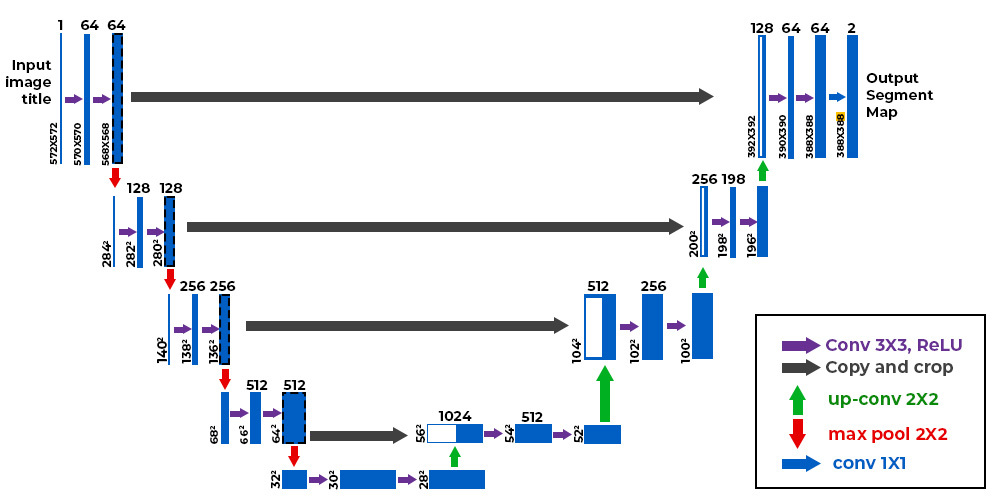

In [ ]:
class UNetBlock(nn.Module):
  def __init__(self,
               shape,
               in_c,
               out_c,
               kernel_size=3,
               stride=1,
               padding=1,
               activation=None,
               normalize=True):
    super().__init__()
    self.ln = nn.LayerNorm(shape)
    self.conv1 = nn.Conv2d(in_channels=in_c,
                           out_channels=out_c,
                           kernel_size=kernel_size,
                           stride=stride,
                           padding=padding)
    self.conv2 = nn.Conv2d(in_channels=out_c,
                           out_channels=out_c,
                           kernel_size=kernel_size,
                           stride=stride,
                           padding=padding)
    self.activation = nn.SiLU() if activation is None else activation
    self.normalize = normalize

  def forward(self, x):
    return self.activation(self.conv2(self.activation(self.conv1(self.ln(x) if self.normalize else x))))

$L$ will represent the maximum number of positions, or vectors, in the embedding:

For each $k = 0$ to $\text{max len} - 1$ (every positional encoding, for each $i = 0$ to $\frac{d_{model}}{2}$(every two elements), set the even element equal to $PE(k, 2i) = sin(\frac{k}{n^{\frac{2i}{d_{model}}}})$, and every odd element equal to $PE(k, 2i + 1) = cos(\frac{k}{n^{\frac{2i}{d_{model}}}})$. Then repeat until there are $d_{model}$ elements in the vector.

$$
PE(k, 2i) = sin(\frac{k}{n^{\frac{2i}{d_{model}}}})
$$

$$
PE(k, 2i + 1) = cos(\frac{k}{n^{\frac{2i}{d_{model}}}})
$$

Where:

- $k$ is the positional encoding ranging from 0 to the max length of the sequence - 1 (index of a word in a sequence)
- $i$ is the dimension index (starting from 0).
- $d_{model}$ is the number of dimensions of the model (the size of the embedding vector)
- $n$ can be set to any number but is usually 10,000

We use sine for even dimensions and cosine for odd dimensions because it creates a set of functions that vary at different frequencies and provide a smooth, continuous encoding of positional information.

Each encoding vector has the same dimensionality, ***d_model***, as an embedding vector. This allows them to be summed. ***k*** represents the position, starting with 0 and going to ***L-1***. The highest number that ***i*** can be set to is ***d_model*** divided by 2 since the equations alternate for each element in the embedding. ***n*** can be set to any value, but the original paper recommends 10,000.

In [ ]:
def positional_encoding(max_length, d_model):
    pe = torch.zeros(max_length, d_model) # Shape of (max_length, d_model)

    # Create position column
    k = torch.arange(0, max_length).unsqueeze(dim=1)

    # Use the log version of the function for positional encodings
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

    # Use sine for the even indices and cosine for the odd indices
    pe[:, 0::2] = torch.sin(k * div_term)
    pe[:, 1::2] = torch.cos(k * div_term)

    return pe

**U-NET Architecture**

U‑Net is a **fully convolutional** network that learns a mapping from an input image to an output image (e.g., a segmentation mask, a de-noised image, etc.). Its name comes from its characteristic **U‑shaped** layout:

1. **Contracting (Encoder) Path**
    1. Gradually **downsamples** the input image, capturing increasingly abstract, global features.
    2. Each block often consists of two 3 x 3 convolutions, each followed by an activation function.
    3. The number of feature channels **doubles** after each block, allowing the network to learn richer features.
    4. After each block, a **downsampling** step reduces the spatial dimension (e.g., using max pooling or strided convolution).
2. **Bottleneck**
    1. The lowest spatial resolution (smallest feature map) where the network captures the most compressed representation.
    2. Captures the most compressed representation of the image.
3. **Expanding (Decoder) Path**
    1. Gradually **upsamples** the feature maps back to the original resolution, recovering spatial details.
    2. The number of feature channels typically **halves** at each step.
4. **Skip Connections**
    1. Directly connect encoder layers to decoder layers of the same scale. This allows the decoder to recover high‑resolution features that would otherwise be lost during downsampling.
    2. This reintroduces high‑resolution details lost in the downsampling path and helps the network localize objects or features.
    3. Downsampling (pooling or strided convolutions) compresses spatial information. Without skip connections, the decoder can struggle to reconstruct fine details.

In [ ]:
class UNet(nn.Module):
  def __init__(self, n_steps=1000, time_emb_dim=100):
    super().__init__()

    # Positional Embedding
    self.time_embed = nn.Embedding(num_embeddings=n_steps, embedding_dim=time_emb_dim)
    self.time_embed.weight.data = positional_encoding(max_length=n_steps, d_model=time_emb_dim)
    self.time_embed.requires_grad_(False)

    self.te1 = self._make_te(time_emb_dim, 1)
    self.b1 = nn.Sequential(
        UNetBlock(shape=(1, 28, 28), in_c=1, out_c=10),
        UNetBlock(shape=(10, 28, 28), in_c=10, out_c=10),
        UNetBlock(shape=(10, 28, 28), in_c=10, out_c=10),
    )
    self.down1 = nn.Conv2d(in_channels=10,
                           out_channels=10,
                           kernel_size=4,
                           stride=2,
                           padding=1)

    self.te2 = self._make_te(time_emb_dim, 10)
    self.b2 = nn.Sequential(
        UNetBlock(shape=(10, 14, 14), in_c=10, out_c=20),
        UNetBlock(shape=(20, 14, 14), in_c=20, out_c=20),
        UNetBlock(shape=(20, 14, 14), in_c=20, out_c=20),
    )
    self.down2 = nn.Conv2d(in_channels=20,
                           out_channels=20,
                           kernel_size=4,
                           stride=2,
                           padding=1)

    self.te3 = self._make_te(time_emb_dim, 20)
    self.b3 = nn.Sequential(
        UNetBlock(shape=(20, 7, 7), in_c=20, out_c=40),
        UNetBlock(shape=(40, 7, 7), in_c=40, out_c=40),
        UNetBlock(shape=(40, 7, 7), in_c=40, out_c=40),
    )
    self.down3 = nn.Sequential(
        nn.Conv2d(in_channels=40,
                  out_channels=40,
                  kernel_size=2,
                  stride=1),
        nn.SiLU(),
        nn.Conv2d(in_channels=40,
                  out_channels=40,
                  kernel_size=4,
                  stride=2,
                  padding=1)
    )

    # Bottleneck
    self.te_mid = self._make_te(time_emb_dim, 40)
    self.b_mid = nn.Sequential(
        UNetBlock(shape=(40, 3, 3), in_c=40, out_c=20),
        UNetBlock(shape=(20, 3, 3), in_c=20, out_c=20),
        UNetBlock(shape=(20, 3, 3), in_c=20, out_c=40),
    )

    self.up1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=40,
                           out_channels=40,
                           kernel_size=4,
                           stride=2,
                           padding=1),
        nn.SiLU(),
        nn.ConvTranspose2d(in_channels=40,
                           out_channels=40,
                           kernel_size=2,
                           stride=1),
    )
    self.te4 = self._make_te(time_emb_dim, 80)
    self.b4 = nn.Sequential(
        UNetBlock(shape=(80, 7, 7), in_c=80, out_c=40),
        UNetBlock(shape=(40, 7, 7), in_c=40, out_c=20),
        UNetBlock(shape=(20, 7, 7), in_c=20, out_c=20),
    )

    self.up2 = nn.ConvTranspose2d(in_channels=20,
                                  out_channels=20,
                                  kernel_size=4,
                                  stride=2,
                                  padding=1)
    self.te5 = self._make_te(time_emb_dim, 40)
    self.b5 = nn.Sequential(
        UNetBlock(shape=(40, 14, 14), in_c=40, out_c=20),
        UNetBlock(shape=(20, 14, 14), in_c=20, out_c=10),
        UNetBlock(shape=(10, 14, 14), in_c=10, out_c=10),
    )

    self.up3 = nn.ConvTranspose2d(in_channels=10,
                                  out_channels=10,
                                  kernel_size=4,
                                  stride=2,
                                  padding=1)
    self.te_out = self._make_te(time_emb_dim, 20)
    self.b_out = nn.Sequential(
        UNetBlock(shape=(20, 28, 28), in_c=20, out_c=10),
        UNetBlock(shape=(10, 28, 28), in_c=10, out_c=10),
        UNetBlock(shape=(10, 28, 28), in_c=10, out_c=10, normalize=False),
    )

    self.conv_out = nn.Conv2d(in_channels=10,
                              out_channels=1,
                              kernel_size=3,
                              stride=1,
                              padding=1)

  def forward(self, x, t):
    # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
    t = self.time_embed(t)
    n = len(x)
    out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
    out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
    out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

    out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

    out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
    out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

    out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
    out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

    out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
    out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

    out = self.conv_out(out)

    return out

  # Transforms the time embedding into a shape suitable to add to feature maps
  def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(in_features=dim_in, out_features=dim_out),
            nn.SiLU(),
            nn.Linear(in_features=dim_out, out_features=dim_out)
        )

In [ ]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = DDPMModel(UNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [ ]:
# Show the diffusion (forward) process
show_forward(ddpm=ddpm, loader=loader, device=device)

Output hidden; open in https://colab.research.google.com to view.

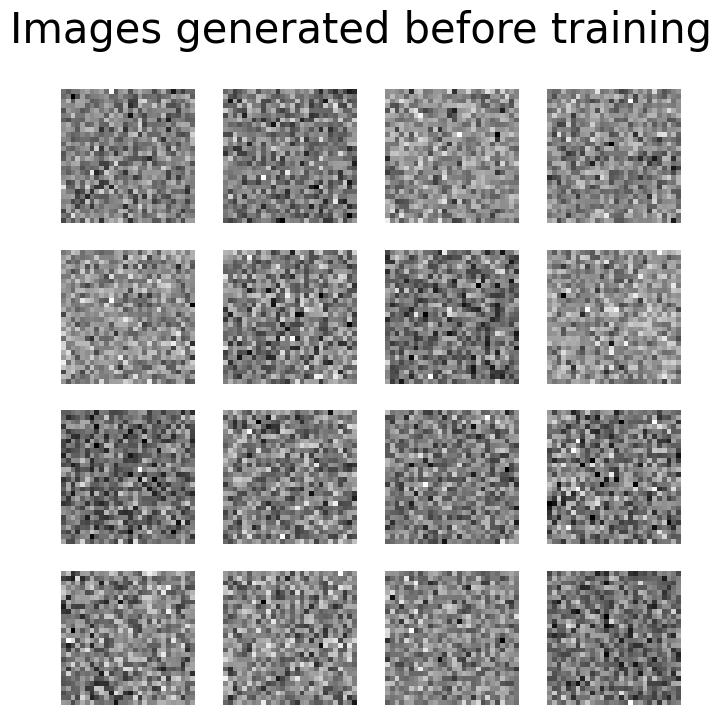

In [ ]:
generated = generate_new_images(ddpm=ddpm)
show_images(generated, "Images generated before training")

In [ ]:
def training_loop(ddpm, loader, n_epochs, optimizer, device, display=False, store_path="ddpm_model.pt"):
    loss_fn = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            X = batch[0].to(device)
            n = len(X)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(X).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Forward Process of Diffusion
            # Computing the noisy image based on X and the time-step
            noisy_imgs = ddpm(X, t, eta)

            # Backward Process of Diffusion
            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Calculate the MSE loss between the model's estimation of noise vs the actual noise used
            loss = loss_fn(eta_theta, eta)

            optimizer.zero_grad()

            # Backpropagation
            loss.backward()

            # Opimizer step
            optimizer.step()

            epoch_loss += loss.item() * len(X) / len(loader.dataset)

        if display:
            show_images(generate_new_images(ddpm=ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Epoch: {epoch + 1} | Loss: {epoch_loss:.6f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Stored"

        print(log_string)

In [ ]:
optimizer = torch.optim.Adam(params=ddpm.parameters(), lr=lr)
training_loop(ddpm=ddpm, loader=loader, n_epochs=epochs, optimizer=optimizer, device=device)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.202516 --> Stored


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | Loss: 0.077157 --> Stored


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | Loss: 0.066915 --> Stored


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | Loss: 0.061354 --> Stored


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | Loss: 0.059232 --> Stored


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | Loss: 0.055950 --> Stored


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | Loss: 0.055478 --> Stored


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | Loss: 0.053424 --> Stored


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | Loss: 0.052738 --> Stored


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | Loss: 0.051187 --> Stored


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | Loss: 0.050925 --> Stored


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | Loss: 0.051693


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | Loss: 0.050247 --> Stored


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | Loss: 0.049928 --> Stored


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | Loss: 0.049193 --> Stored


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | Loss: 0.048945 --> Stored


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | Loss: 0.048988


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | Loss: 0.048311 --> Stored


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | Loss: 0.047468 --> Stored


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | Loss: 0.047567


In [ ]:
# Loading the trained model
best_model = DDPMModel(UNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


<ipython-input-25-f420cec23211>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(store_path, map_location=device))


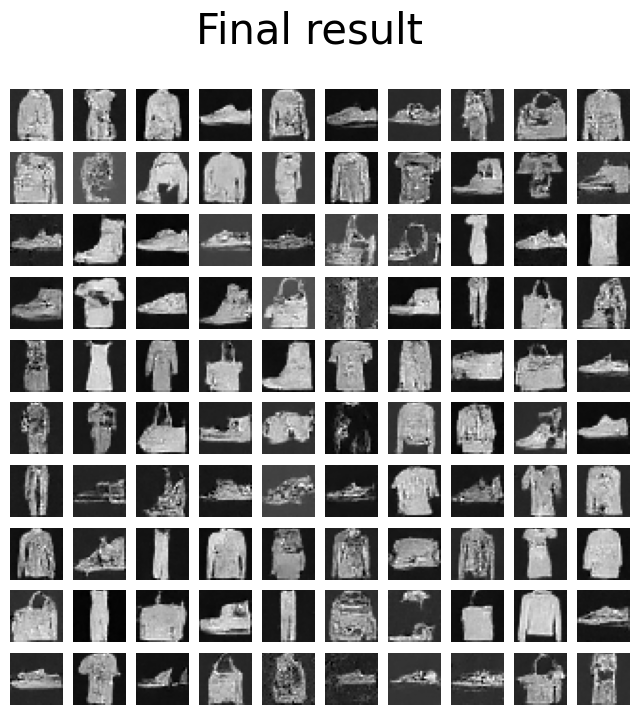

In [ ]:
generated = generate_new_images(
        ddpm=best_model,
        n_samples=100,
        device=device,
    )
show_images(generated, "Final result")